# Análisis de encuesta de medios de estudio.

El análisis estará dividido entre lo que fue encargado como ejercicios para la segunda parte de la Fase II del trabajo experimental, y aquello que fue realizado para enrriquecer la presentación que se dará en clase acerca de la encuesta.

## Segunda parte, Fase II

In [1]:
import pandas as pd

data = pd.read_csv('../data/results.csv')


### 1 - Binomial, Bernoulli y Possion.

In [2]:
rand_var = 'computer_availability'
table = data[rand_var].value_counts()  # Frequency table.
table


Tengo un computador de uso personal.                               38
Tengo un computador que debo compartir con alguien más en casa.     5
No tengo un computador en casa.                                     1
Name: computer_availability, dtype: int64

In [3]:
# Primero definimos su función de probabilidad para Bernoulli.
def bernoulli(x: int, alpha: float) -> float:
    if x == 0:
        return 1 - alpha
    elif x == 1:
        return alpha
    else:
        return 0


# Para 'Tengo un computador de uso personal.'.
x1 = 'Tengo un computador de uso personal.'
alpha = table.loc[x1] / data[rand_var].value_counts().sum()
index = data[rand_var].sample(1).value_counts().index[0]  # Para n = 1.
x = 1 if index == x1 else 0

bernoulli(x, alpha)


0.8636363636363636

In [4]:
rand_var = 'computers_satisfaction'
table = data[rand_var].value_counts()
x1 = 'Muy insatisfecho.'
alpha = table.loc[x1] / data[rand_var].value_counts().sum()
index = data[rand_var].sample(1).value_counts().index[0]  # Para n = 1.
x = 1 if index == x1 else 0

bernoulli(x, alpha)


0.9318181818181819

In [5]:
import math


def binomial(x: int, n: int, p: float) -> float:
    if x not in range(n):
        return 0
    else:
        return math.comb(n, x) * ((p ** x) * (1 - p) ** (n - x))


rand_var = 'computer_availability'
table = data[rand_var].value_counts()  # Frequency table.
x1 = 'No tengo un computador en casa.'
p = table.loc[x1] / data[rand_var].value_counts().sum()
n = 10  # Para n = 10.

binomial(1, n, p)


0.1847946251383883

In [6]:
rand_var = 'computers_satisfaction'
table = data[rand_var].value_counts()  # Frequency table.
x1 = 'Muy insatisfecho.'
p = table.loc[x1] / data[data[rand_var] != 'No lo usa.'][rand_var].value_counts().sum()
n = 10

print('{:.2f}'.format(binomial(1, n, p)))


0.37


In [7]:
from IPython.display import Math


def poisson(x: int, λ: float) -> float:
    return ((math.e ** (-λ)) * (λ ** x)) / math.factorial(x)


rand_var = 'computer_availability'
table = data[rand_var].value_counts()  # Frequency table.
x1 = 'No tengo un computador en casa.'
# Usamos un p pequeño para mejorar la aproximación.
p = table.loc[x1] / data[rand_var].value_counts().sum()

n = 30
λ = n * p
print(f"{λ=}")

bino = binomial(1, n, p)
poiss = poisson(1, λ)

print(f"{bino=}")
print(f"{poiss=}")
Math(r"b(1; {n}, {p:.2}) = {bino:.2} \approx p(1; {λ:.2}) = {poiss:.2}".format(
    n=n, p=p, bino=bino, λ=λ, poiss=poiss))


λ=0.6818181818181819
bino=0.3500468484393231
poiss=0.3447932096164585


<IPython.core.display.Math object>

### 2 - Distribución normal.

In [8]:
import numpy as np

rand_var = 'monthly_expenses'

# Como la variable que vamos a usar tiene defectos de entrada, los arreglaremos.
# Primero, añadiremos 3 ceros a los valores que no representan un valor en la moneda colombiana.
data.loc[data[rand_var] < 50, rand_var] *= 1000

# Ahora removeremos los que son menos de 1000 pesos ya que son poco creibles pero tampoco pueden ser normalizados simplemente añadiéndoles 3 ceros.
indeces = data[(data[rand_var] != 0) & (data[rand_var] < 1000)].index
data.drop(indeces, inplace=True)

n_samp = 33
samp = data.sample(n_samp)[rand_var]
samp_data = np.array(samp.values)

# Usaré la media de todos los datos de la encuesta como μ, y los de la muestra la media muestral.
μ = data[rand_var].sum() / data[rand_var].size
# Varianza insesgada (n - 1).
vrc = ((samp_data - μ) ** 2).sum() / (n_samp - 1)
σ = math.sqrt(vrc)

print(f"{µ=}")
print(f"{vrc=}")
print(f"{σ=}")


µ=34116.666666666664
vrc=905730703.1250001
σ=30095.360159416603


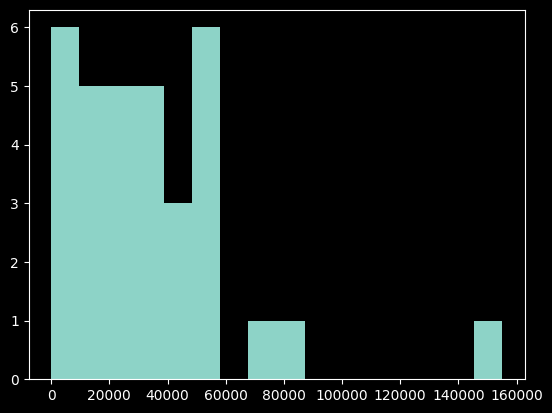

In [9]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

plt.hist(samp_data, bins=samp_data.size // 2)
plt.show()


In [10]:
from z_lookup import z_lookup


def Φ(z: float) -> float:
    z = abs(z)
    return z_lookup.at[float('0.0' + f'{z:.3}'[-1]), math.trunc(z * 10) / 10]


def Z(X: int | float, μ: float, sigma: float) -> float:
    return (X - μ) / sigma


In [11]:
# Exactamente 100000.
X1 = 1e5
Z1 = Z(X1, μ, σ)
P1 = Φ(Z1)
P1


0.4857

In [12]:
# Al menos 50000.
X2 = 5e4
Z2 = Z(X2, μ, σ)
P2 = 1 - Φ(Z2)
P2


0.781

### 3 - Intérvalos de confianza.

In [13]:
import numpy as np
import sys

trust_values = [70, 80, 90]
zs = [x / 200 for x in trust_values]

closest = []
for z in zs:
    b = (z_lookup - z).abs()
    min_col = 0
    min_row = 0
    min_val = sys.float_info.max
    for i, col in enumerate(b):
        for j, row in enumerate(b[col]):
            if row < min_val:
                min_col = i
                min_row = j
                min_val = row

    closest.append(z_lookup.columns[min_col] + z_lookup.index[min_row])


def error(z: float, σ: float, N: int) -> float:
    return z * (σ / math.sqrt(N))


mean = (samp_data.sum()) / samp_data.size

intervals = [(mean - error(z, σ, n_samp), mean + error(z, σ, n_samp))
             for z in closest]
intervals


[(26612.11911884457, 37509.09300236755),
 (25354.775978438072, 38766.436142774044),
 (23468.761267828326, 40652.450853383794)]

### 4 - Pruebas de hipótesis (Distribución Normal)

$$H_{0}: \mu = \$50.000COP $$
$$H_{A}: \mu < \$50.000COP $$

In [14]:
from scipy import stats
from scipy.stats import norm

hyp = 5e4
stats.zmap(data[rand_var], stats.zscore(data[rand_var]))


0     5.000000e+04
1     1.000000e+04
2     1.000000e+04
3     5.000000e+04
4    -7.930164e-17
5     2.000000e+04
6     4.000000e+04
7     5.000000e+03
9     5.000000e+04
10    5.000000e+03
12    1.500000e+04
13    2.000000e+04
14    5.000000e+04
15    1.500000e+05
16   -7.930164e-17
17    3.000000e+04
18    3.000000e+04
19    2.000000e+04
20    3.300000e+04
21    3.000000e+04
22    4.000000e+04
23    3.000000e+04
24    5.000000e+04
25    1.000000e+04
26    4.000000e+04
27    7.500000e+04
28    5.490000e+04
29    1.500000e+04
30    2.000000e+04
31    1.500000e+04
32    3.000000e+04
33    7.000000e+04
34    1.550000e+05
35   -7.930164e-17
36    8.000000e+04
37    5.000000e+03
38    1.500000e+04
39    5.000000e+04
40    3.000000e+04
41    1.000000e+04
42    2.000000e+04
43   -7.930164e-17
Name: monthly_expenses, dtype: float64

### 5 - Pruebas de hipótesis (Distribución T-Student)

In [15]:
# Hipótesis.
null_hyp = 5e4
α = 0.05

statistic, pvalue = stats.ttest_1samp(samp_data, null_hyp)
if pvalue < α:
    print('Hipótesis no fue rechazada')
else:
    print('La hipótesis rechazada')

Hipótesis no fue rechazada


## Análisis para la presentación

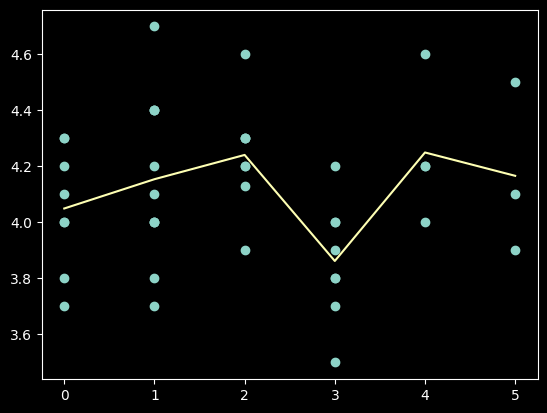

In [16]:
by_lib_hrs = data.sort_values('library_per_week', ascending=True).reset_index()
plt.plot('library_per_week', 'papa', 'o', data=by_lib_hrs)

newy = []
for i, papa in by_lib_hrs['papa'].items():
    lpw = by_lib_hrs['library_per_week'].iat[i]
    papas_at_lpw = by_lib_hrs[by_lib_hrs['library_per_week'] == lpw]['papa']
    newy.append(papas_at_lpw.mean())

plt.plot(by_lib_hrs['library_per_week'], newy)
plt.show()


Biblioteca Gabriel García Márquez                             17
Biblioteca de Ciencia y Tecnología                            32
Sala Central de Informática                                    9
Biblioteca de Posgrados de Ciencias Humanas - Ernesto Guhl     5
Hemeroteca Nacional Universitaria - Carlos Lleras Restrepo     3
Sala de Historia - Jaime Jaramillo Uribe                       1
Biblioteca de Ciencias Agrarias                                2
dtype: int64


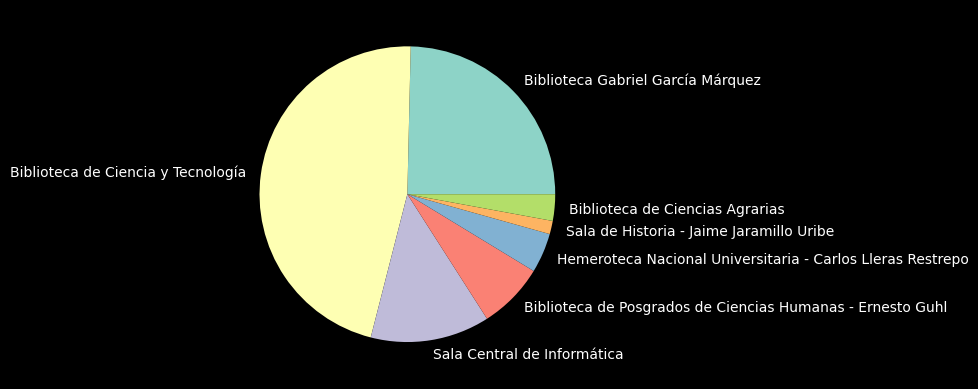

In [17]:
used_libraries_as_set = []
for s in data['used_libraries']:
    used_libraries_as_set.append(set(s.split(', ')) if type(s) is str else s)

data['used_libraries'] = used_libraries_as_set
count_used_lbs = {}
for set_used_lbs in data['used_libraries']:
    try:

        for lib in set_used_lbs:
            if lib in count_used_lbs:
                count_used_lbs[lib] += 1
            else:
                count_used_lbs[lib] = 1
    except (TypeError):
        continue

count_used_lbs = pd.Series(count_used_lbs)
print(count_used_lbs)
plt.pie(count_used_lbs, labels=count_used_lbs.index)
plt.show()


In [18]:
all_libs = count_used_lbs.index.copy()
sat_lvls = ['Muy insatisfecho.', 'Insatisfecho.',
            'Neutro.', 'Satisfecho.', 'Muy satisfecho.']

marginal = pd.DataFrame(
    0,
    columns=sat_lvls,
    index=all_libs)

marginal.loc['Total'] = 0
marginal['Total'] = 0

for i in data.index:
    satisfaction = data.loc[i, 'computers_satisfaction']
    if satisfaction == 'No lo usa.':
        continue
    libs = data.loc[i, 'used_libraries']

    try:
        for lib in libs:
            marginal.loc[lib, satisfaction] += 1
            marginal.loc[lib]['Total'] += 1
            marginal.loc['Total']['Total'] += 1
            marginal.loc['Total',
                         satisfaction] = marginal.at['Total', satisfaction] + 1
    except (TypeError):
        continue


marginal


,Muy insatisfecho.,Insatisfecho.,Neutro.,Satisfecho.,Muy satisfecho.,Total
Biblioteca Gabriel García Márquez,2,2,6,6,1,17
Biblioteca de Ciencia y Tecnología,3,7,9,10,1,30
Sala Central de Informática,0,3,1,4,0,8
Biblioteca de Posgrados de Ciencias Humanas - Ernesto Guhl,1,1,3,0,0,5
Hemeroteca Nacional Universitaria - Carlos Lleras Restrepo,0,1,0,2,0,3
Sala de Historia - Jaime Jaramillo Uribe,0,1,0,0,0,1
Biblioteca de Ciencias Agrarias,0,1,1,0,0,2
Total,6,16,20,22,2,66


In [19]:
total = marginal.at['Total', 'Total']
bdfs = []

for lib in all_libs:
    bdf = pd.DataFrame()
    for lvl in sat_lvls:
        priori = marginal.at['Total', lvl] / total
        bdf.at[lvl, 'Priori'] = priori
        bdf.at[lvl, 'Conditional'] = marginal.at[lib, lvl] / \
            marginal.at[lib, 'Total']
        bdf.at[lvl, 'Both'] = bdf.at[lvl, 'Conditional'] * \
            bdf.at[lvl, 'Priori']

    both_sum = bdf['Both'].sum()
    if both_sum == 0:
        bdf['Both'] = 0
        continue

    for lvl in sat_lvls:
        bdf.at[lvl, 'Posteriori'] = bdf.at[lvl, 'Both'] / both_sum

    bdfs.append(bdf)


In [20]:
print(all_libs[0])
bdfs[0]


Biblioteca Gabriel García Márquez


,Priori,Conditional,Both,Posteriori
Muy insatisfecho.,0.090909,0.117647,0.010695,0.040268
Insatisfecho.,0.242424,0.117647,0.028520,0.107383
Neutro.,0.303030,0.352941,0.106952,0.402685
Satisfecho.,0.333333,0.352941,0.117647,0.442953
Muy satisfecho.,0.030303,0.058824,0.001783,0.006711


In [21]:
# Probabilidad de que esté satisfecho dado que haya usado la biblioteca del CyT.
sum_sats = bdfs[0].loc[['Satisfecho.','Muy satisfecho.'], 'Posteriori'].sum()
print('Satisfecho, Muy satisfecho: {:.2f}%'.format(sum_sats * 100))
print('El resto: {:.2f}%'.format((1 - sum_sats) * 100))


Satisfecho, Muy satisfecho: 44.97%
El resto: 55.03%


In [22]:
print(all_libs[1])
bdfs[1]


Biblioteca de Ciencia y Tecnología


,Priori,Conditional,Both,Posteriori
Muy insatisfecho.,0.090909,0.100000,0.009091,0.033835
Insatisfecho.,0.242424,0.233333,0.056566,0.210526
Neutro.,0.303030,0.300000,0.090909,0.338346
Satisfecho.,0.333333,0.333333,0.111111,0.413534
Muy satisfecho.,0.030303,0.033333,0.001010,0.003759


In [23]:
# Probabilidad de que esté satisfecho dado que haya usado la Biblioteca Central.
sum_sats = bdfs[1].loc[['Satisfecho.', 'Muy satisfecho.'], 'Posteriori'].sum()
print('Satisfecho, Muy satisfecho: {:.2f}%'.format(sum_sats * 100))
print('El resto: {:.2f}%'.format((1 - sum_sats) * 100))


Satisfecho, Muy satisfecho: 41.73%
El resto: 58.27%
